## Lab 1. Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

### Set the environment

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

!pip install nltk
!pip install -U torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U torchtext==0.9.0
!pip install youtokentome

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/22s_advanced/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [3]:
%%writefile my_network.py
import torch
import torch.nn as nn
import torch.optim as optim

import random
import math
import time


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
        
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
                
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        # assert encoder.n_layers == decoder.n_layers, \
        #    "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

Overwriting my_network.py


In [4]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_advanced/Lab1_NLP/my_network.py -nc

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchtext
from torchtext.legacy.data import Field, RawField, BucketIterator, TabularDataset

import spacy
import youtokentome as yttm

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()

def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9316
Unique tokens in target (en) vocabulary: 6688


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'гранд',
 'бесплатных',
 'коктейлей',
 'jardin',
 'частные',
 'peace',
 'художественные',
 'доступный',
 'стоящая']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>',
 'exploring',
 'lighthouse',
 'daylight',
 'money',
 'serenity',
 'macerata']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['it', 'is', 'a', '10', '-', 'minute', 'drive', 'from', 'jiuzhou', 'port', 'and', 'a', '30', '-', 'minute', 'drive', 'from', 'hengqin', 'port', 'or', 'chimelong', 'ocean', 'international', 'tourist', 'resort', '.'], 'src': ['поездка', 'до', 'порта', 'цзючжоу', 'займет', '10', 'минут', ',', 'а', 'за', '30', 'минут', 'можно', 'доехать', 'до', 'порта', 'хэнцзинь', 'и', 'международного', 'туристического', 'курорта', 'chimelong', 'ocean', '.']}


Let's check the length distributions:

Length distribution in Train data


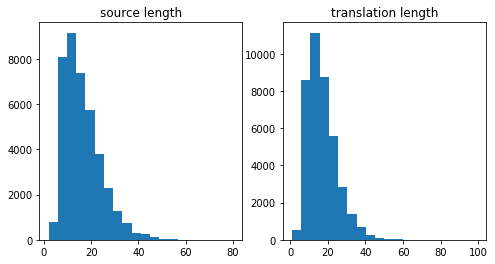

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


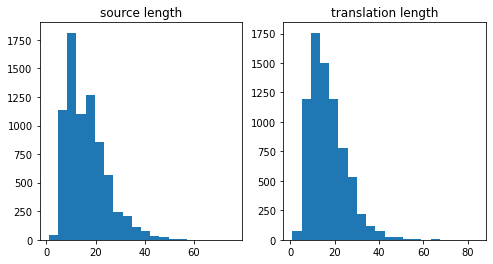

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
import my_network


Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9288, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6736, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6736, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,914,128 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.2)

In [ ]:
def train(model, iterator, optimizer, criterion, max_grad_norm, 
          lr_scheduler=None, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    if not lr_scheduler is None:
        lr_scheduler.step()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 20
MAX_GRAD_NORM = 1

best_valid_loss = float('inf')

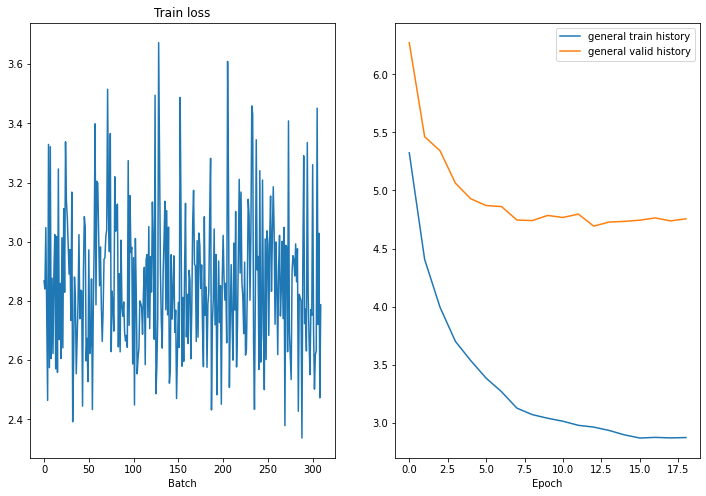

Epoch: 20 | Time: 3m 16s
	Train Loss: 2.857 | Train PPL:  17.411
	 Val. Loss: 4.764 |  Val. PPL: 117.200


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, 
                       MAX_GRAD_NORM, lr_scheduler, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp


imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: meals can be enjoyed in the dining area .
Generated: there is a seating area and a .

Original: free parking can be found on site .
Generated: featuring free wifi .



In [7]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
original_text = []
generated_text = []
model.eval()

with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:06,  8.77it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.180510473291758

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

**Вывод:** Обычная Seq2Seq модель с токенизатором, разбивающим текст на отдельные слова, показывает невысокое качество в задаче машинного перевода. 

Далее, все нижеприведённые модели используют BPE-токенизатор, который создаёт словарь токенов жадным способом

### BPE  
[Источник](https://github.com/VKCOM/YouTokenToMe)

**Сохранеие русского и английского текстов из обучающей выборки по файлам**

In [ ]:
from pathlib import Path


def build_train_corpus(train_data, field, filename):
    assert field in train_data.fields.keys()

    with open(filename, "w") as fout:
        for elem in train_data:
            fout.write(" ".join(vars(elem)[field]))
            fout.write("\n")

def build_train_src_corpus(train_data, filename):
    return build_train_corpus(train_data, "src", filename)

def build_train_trg_corpus(train_data, filename):
    return build_train_corpus(train_data, "trg", filename)

Path("./bpe_train_data").mkdir(exist_ok=True)
build_train_src_corpus(train_data, "./bpe_train_data/src_corpus.txt")
build_train_trg_corpus(train_data, "./bpe_train_data/trg_corpus.txt")

**Обучение Byte-Pair Encoder-а**

In [ ]:
SRC_VOCAB_SIZE = 7000
TRG_VOCAB_SIZE = 5000

Path("./bpe_models").mkdir(exist_ok=True)

bpe_src = yttm.BPE.train(data="./bpe_train_data/src_corpus.txt", 
                          model="./bpe_models/src_model", 
                          vocab_size=SRC_VOCAB_SIZE, 
                          coverage=0.999, 
                          n_threads=-1)

bpe_trg = yttm.BPE.train(data="./bpe_train_data/trg_corpus.txt", 
                          model="./bpe_models/trg_model", 
                          vocab_size=TRG_VOCAB_SIZE, 
                          coverage=0.999, 
                          n_threads=-1)

**Применение обученных токенизаторов**

In [ ]:
bpe_src.encode(["атмосфера - верхний слой поверхности земли."], 
               output_type=yttm.OutputType.SUBWORD,
               dropout_prob=0.1)

[['▁атмосфера',
  '▁-',
  '▁верх',
  'ний',
  '▁с',
  'лой',
  '▁по',
  'вер',
  'х',
  'ности',
  '▁зем',
  'ли',
  '.']]

In [ ]:
bpe_trg.encode(["the atmosphere is the upper layer of the earth's surface."], 
               output_type=yttm.OutputType.SUBWORD,
               dropout_prob=0.1)

[['▁the',
  '▁atmosphere',
  '▁i',
  's',
  '▁the',
  '▁upper',
  '▁l',
  'ay',
  'er',
  '▁of',
  '▁the',
  '▁ear',
  'th',
  "'",
  's',
  '▁surf',
  'ace',
  '.']]

**Создание датасета с BPE и итераторов**

In [ ]:
def bpe_tokenize(text, bpe_tokenizer, dropout_proba=0.1):
    return bpe_tokenizer.encode([text.lower()], 
                                output_type=yttm.OutputType.ID,
                                dropout_prob=dropout_proba)[0]

bpe_src_tokenize = lambda text: bpe_tokenize(text, bpe_src)
bpe_trg_tokenize = lambda text: bpe_tokenize(text, bpe_trg)

SRC = Field(tokenize=bpe_src_tokenize,
            init_token=bpe_src.subword_to_id('<BOS>'), 
            eos_token=bpe_src.subword_to_id('<EOS>'), 
            pad_token=bpe_src.subword_to_id('<PAD>'),
            unk_token=bpe_src.subword_to_id('<UNK>'),
            use_vocab=False)

TRG = Field(tokenize=bpe_trg_tokenize,
            init_token=bpe_trg.subword_to_id('<BOS>'), 
            eos_token=bpe_trg.subword_to_id('<EOS>'), 
            pad_token=bpe_trg.subword_to_id('<PAD>'),
            unk_token=bpe_trg.subword_to_id('<UNK>'),
            use_vocab=False)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=lambda x: len(x.src)
)

### CNN encoder with positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, device, denom_basement=10000, max_seq_len=128):
        super().__init__()

        positions = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.pow(torch.arange(0, emb_dim, 2) / emb_dim, denom_basement)

        pe = torch.zeros(max_seq_len, 1, emb_dim).to(device)
        pe[:, 0, 0::2] = torch.sin(positions * div_term)
        pe[:, 0, 1::2] = torch.cos(positions * div_term)

        self.pe = pe

    def forward(self, x):
        #x: [seq_len, batch_size, embedding_dim]

        return x + self.pe[:x.size(0)]

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, device, max_seq_len=128, dropout=0.2):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        
        self.embedding = nn.Sequential(
            nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim),
            PositionalEncoding(emb_dim, device, max_seq_len=max_seq_len)
        )

        self.dropout = nn.Dropout(p=dropout)

        self.conv_for_hidden = nn.Sequential(
            nn.Conv1d(emb_dim, 2*emb_dim, kernel_size=2, padding=1), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv1d(2*emb_dim, 2*emb_dim, kernel_size=2, padding=1), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv1d(2*emb_dim, 2*emb_dim, kernel_size=2, padding=1), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv1d(2*emb_dim, hid_dim, kernel_size=2, padding=1), 
            nn.BatchNorm1d(hid_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), 
            nn.Linear(hid_dim, hid_dim)
        )

        self.conv_for_cell = nn.Sequential(
            nn.Conv1d(emb_dim, 2*emb_dim, kernel_size=3, padding=1), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv1d(2*emb_dim, 2*emb_dim, kernel_size=3, padding=1), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv1d(2*emb_dim, 2*emb_dim, kernel_size=3, padding=1), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.Conv1d(2*emb_dim, hid_dim, kernel_size=3, padding=1), 
            nn.BatchNorm1d(hid_dim), 
            nn.LeakyReLU(inplace=True), 

            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), 
            nn.Linear(hid_dim, hid_dim)
        )
                
    def forward(self, src):
        #src = [src sent len, batch size]
        embedded = self.dropout(self.embedding(src))

        #[seq_len, batch_size, emb_size] -> [batch_size, emb_size, seq_len]
        embedded = embedded.permute((1, 2, 0))

        hidden = self.conv_for_hidden(embedded).unsqueeze(0)
        cell = self.conv_for_cell(embedded).unsqueeze(0)
        
        return hidden, cell


**Создание модели**

In [ ]:
INPUT_DIM = SRC_VOCAB_SIZE
OUTPUT_DIM = TRG_VOCAB_SIZE
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
MAX_SRC_SENT_LEN = max(map(lambda df_elem: len(df_elem.src), dataset.examples)) + 2

enc = CNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, device, MAX_SRC_SENT_LEN, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,339,080 trainable parameters


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param, std=0.1)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): CNNEncoder(
    (embedding): Sequential(
      (0): Embedding(7000, 256)
      (1): PositionalEncoding()
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (conv_for_hidden): Sequential(
      (0): Conv1d(256, 512, kernel_size=(2,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
      (6): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(1,))
      (10): BatchNorm1d(512, eps=1e-05, momentum=0.

In [ ]:
PAD_IDX = TRG.pad_token
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.2)

train_history = []
valid_history = []

N_EPOCHS = 15
MAX_GRAD_NORM = 1

best_valid_loss = float('inf')

**Обучение модели**

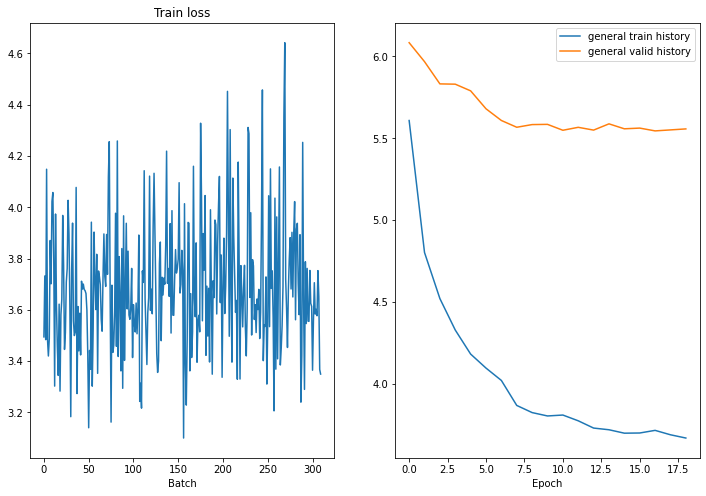

Epoch: 15 | Time: 3m 46s
	Train Loss: 3.687 | Train PPL:  39.936
	 Val. Loss: 5.549 |  Val. PPL: 257.023


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, 
                       MAX_GRAD_NORM, lr_scheduler, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

**Оценка качества модели**

In [ ]:
def get_text(x, bpe_tokenizer):
    return bpe_tokenizer.decode([x], ignore_ids=[0, 2, 3])

def generate_translation(src, trg, model, bpe_tokenizer):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), bpe_tokenizer)
    generated = get_text(list(output[1:, 0]), bpe_tokenizer)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [ ]:
batch = next(iter(test_iterator))

for idx in range(1, 10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, bpe_trg)

Original: the bathroom is fitted with a shower.
Generated: the bathroom comes with a shower....

Original: some rooms include a seating area to relax in after a busy day.
Generated: certain units feature a seating area where you can relax.

Original: sauna facility is also available on site.
Generated: a fitness centre is available...

Original: guests can enjoy the on-site restaurant.
Generated: guests can enjoy the on-site restaurant. restaurant.

Original: public parking at a nearby location is for free.
Generated: free public parking is available nearby......

Original: free wifi is featured .
Generated: free wifi is available..

Original: the private bathroom comes with a hairdryer.
Generated: the private bathroom comes with a shower and hairdryer..

Original: free wifi access is available.
Generated: free wifi access is available...

Original: there is a 24-hour front desk at the property.
Generated: there is a 24-hour front desk at the property..



In [ ]:
original_text = []
generated_text = []
model.eval()

with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, bpe_trg) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, bpe_trg) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:07,  7.91it/s]
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


21.819606517293646

### Attention in Seq2Seq

In [ ]:
class AttentionEncoder(Encoder):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__(input_dim, emb_dim, hid_dim, n_layers, dropout)
        
    def forward(self, src):
        #src = [src sent len, batch size]
        embedded = self.dropout(self.embedding(src))
        output, (hidden, cell) = self.rnn(embedded)
        
        return output, hidden, cell

class AttentionDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )

        self.softmax = nn.Softmax(dim=2)
        
        self.rnn = nn.LSTM(
            input_size=emb_dim+n_layers*hid_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.out = nn.Linear(hid_dim, output_dim)
                
    def forward(self, input, enc_hidden, dec_hidden, dec_cell):
        #input = [batch size]
        #enc_hidden = [seq_len, batch size, hid dim]
        #dec_hidden = [n_layers, batch size, hid dim]
        #dec_cell = [n_layers, batch size, hid dim]
        
        batch_size = dec_hidden.shape[1]
        input = input.unsqueeze(0)
                
        #embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(input))

        #hidd_dot_prod = [batch size, n_layers, seq_len]
        hidd_dot_prod = torch.einsum("sbh, nbh -> bns", enc_hidden, dec_hidden)

        #hidd_coeff = [batch size, n_layers, seq_len]
        hidd_coeff = self.softmax(hidd_dot_prod)

        #attention_hidd = [batch size, n_layers, hid dim]
        attention_hidd = torch.einsum("sbh, bns -> bnh", enc_hidden, hidd_coeff)

        #attention_hidd = [1, batch size, n_layers*hid dim]
        attention_hidd = attention_hidd.reshape(1, batch_size, -1)

        modified_input = torch.cat([attention_hidd, embedded], dim=-1)

        output, (hidden, cell) = self.rnn(modified_input, (dec_hidden, dec_cell))
        
        #output = [1, batch_size, hid_dim]
        #prediction = [batch size, output dim]
        prediction = self.out(output.squeeze(0))
        
        return prediction, hidden, cell

In [ ]:
class AttentionSeq2Seq(Seq2Seq):
    def __init__(self, encoder, decoder, device):
        super().__init__(encoder, decoder, device)
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_output, dec_hidden, dec_cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            output, dec_hidden, dec_cell = self.decoder(input, 
                                                        enc_output, 
                                                        dec_hidden, 
                                                        dec_cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(dim=1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

**Создание модели**

In [ ]:
INPUT_DIM = SRC_VOCAB_SIZE
OUTPUT_DIM = TRG_VOCAB_SIZE
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 384
N_LAYERS = 3
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4

enc = AttentionEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = AttentionSeq2Seq(enc, dec, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,469,576 trainable parameters


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param, std=0.1)
        
model.apply(init_weights)

AttentionSeq2Seq(
  (encoder): AttentionEncoder(
    (embedding): Embedding(7000, 256)
    (rnn): LSTM(256, 384, num_layers=3, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): AttentionDecoder(
    (dropout): Dropout(p=0.4, inplace=False)
    (embedding): Embedding(5000, 256)
    (softmax): Softmax(dim=2)
    (rnn): LSTM(1408, 384, num_layers=3, dropout=0.4)
    (out): Linear(in_features=384, out_features=5000, bias=True)
  )
)

In [ ]:
PAD_IDX = TRG.pad_token
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.2)

train_history = []
valid_history = []

N_EPOCHS = 20
MAX_GRAD_NORM = 5

best_valid_loss = float('inf')

**Обучение модели**

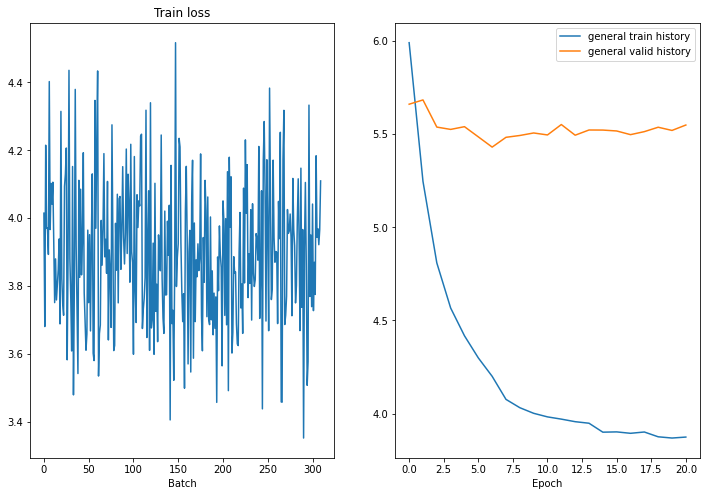

Epoch: 20 | Time: 2m 35s
	Train Loss: 3.893 | Train PPL:  49.065
	 Val. Loss: 5.532 |  Val. PPL: 252.668


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, 
                       MAX_GRAD_NORM, lr_scheduler, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

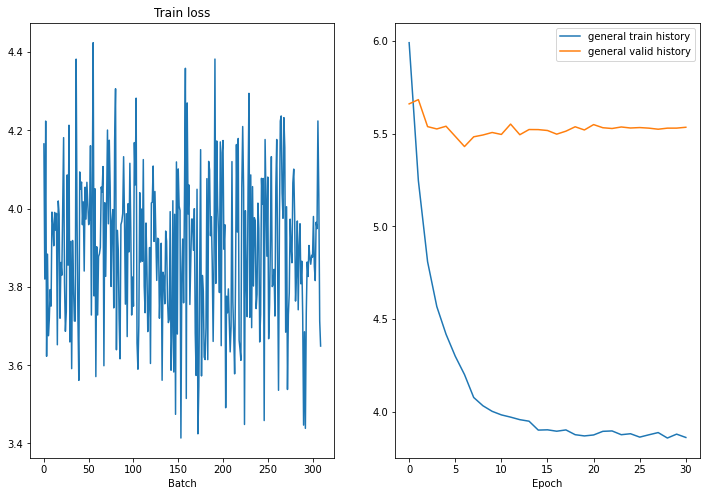

Epoch: 05 | Time: 2m 35s
	Train Loss: 3.888 | Train PPL:  48.828
	 Val. Loss: 5.531 |  Val. PPL: 252.425


In [ ]:
for epoch in range(5):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, 
                       MAX_GRAD_NORM, lr_scheduler, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

**Оценка качества модели**

In [ ]:
batch = next(iter(test_iterator))

for idx in range(1, 101, 10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, bpe_trg)

Original: free private parking is available.
Generated: free private parking is available..

Original: free wifi is provided.
Generated: free wifi access.

Original: the property offers free parking.
Generated: free parking is available.

Original: parking is free on site.
Generated: free parking is available.

Original: the property offers free parking.
Generated: free parking is available.

Original: the bathroom comes with a shower.
Generated: a private bathroom with a shower..

Original: a tv is offered.
Generated: accommodation with a flat-screen tv..

Original: meals can be enjoyed at the dining table.
Generated: a kitchen with a refrigerator..

Original: there is a 24-hour front desk at the property.
Generated: a 24-hour front desk. desk.

Original: free wi-fi access is available.
Generated: free wifi access is available.



In [ ]:
original_text = []
generated_text = []
model.eval()

with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, bpe_trg) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, bpe_trg) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:06,  9.11it/s]
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


28.716217110259006

### Pretrained transformer
[Ссылка на модель](https://huggingface.co/docs/transformers/main/en/model_doc/marian#transformers.MarianModel)

In [8]:
!pip install -Uqq transformers
!pip install -q sentencepiece

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device)

Число параметров модели

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 76,147,712 trainable parameters


Создание датасета под предобученную модель

In [11]:
SRC = RawField(preprocessing=lambda text: text.lower())
TRG = RawField(preprocessing=lambda text: text.lower())

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=lambda x: len(x.src), 
    sort=True
)

Метрика BLEU предобученной модели

In [34]:
original_text = []
generated_text = []
model.eval()

with torch.no_grad():
    for i, batch_text in tqdm.tqdm(enumerate(test_iterator)):
        src_text = batch_text.src
        trg_text = batch_text.trg

        src_batch = tokenizer(src_text, return_tensors='pt', padding=True).to(device)

        generated_ids = model.generate(src_batch['input_ids'])
        
        original_text.extend(trg_text)

        output_text = tokenizer.batch_decode(generated_ids.cpu().tolist(), 
                                             skip_special_tokens=True)
        generated_text.extend(output_text)

        assert len(trg_text) == len(output_text)

        del src_batch, generated_ids, src_text, trg_text
        torch.cuda.empty_cache()

corpus_bleu([[text] for text in original_text], generated_text) * 100

0it [00:00, ?it/s]


RuntimeError: ignored

Дообучение модели

In [ ]:
model.model.requires_grad = False
model.lm_head.requires_grad = True

N_EPOCHS = 10
PAD_IDX = tokenizer.pad_token_id

optimizer = optim.Adam(model.lm_head.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.2)

train_history = []
valid_history = []
best_valid_loss = float('inf')

In [ ]:
def train_epoch(model, iterator, optimizer, criterion, tokenizer, 
                lr_scheduler=None, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []

    for i, batch_text in enumerate(iterator):
        src_text = batch_text.src
        trg_text = batch_text.trg

        src_batch = tokenizer(src_text, return_tensors='pt', padding=True).to(device)
        src_ids, src_mask = src_batch.values()
        trg_ids = tokenizer(trg_text, return_tensors='pt', padding=True)['input_ids'].to(device)
        
        optimizer.zero_grad()
        
        #trg_ids = [batch_size, seq_length]
        #output = [batch_size, seq_length, vocab_size]
        output = model.forward(src_ids, src_mask).logits

        output = output[1:].view(-1, output.shape[-1])
        trg_ids = trg_ids.view(-1)
        
        loss = criterion(output, trg_ids)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    if not lr_scheduler is None:
        lr_scheduler.step()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate_epoch(model, iterator, criterion, tokenizer):
    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch_text in enumerate(iterator):
            src_text = batch_text.src
            trg_text = batch_text.trg

            src_batch = tokenizer(src_text, return_tensors='pt', padding=True).to(device)
            src_ids, src_mask = src_batch.values()
            trg_ids = tokenizer(trg_text, return_tensors='pt', padding=True)['input_ids'].to(device)

            #trg_ids = [batch_size, seq_length]
            #output = [batch_size, seq_length, vocab_size]
            output = model.forward(src_ids, src_mask).logits
            output = output[1:].view(-1, output.shape[-1])
            trg_ids = trg_ids.view(-1)

            loss = criterion(output, trg_ids)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, 
                       tokenizer, lr_scheduler, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion, tokenizer)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')